In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32

In [2]:
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

/opt/homebrew/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_dl = DataLoader(train, batch_size=batch_size)
test_dl = DataLoader(test, batch_size=batch_size)

In [4]:
train_mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_mnist = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:

train_mnist_dl = DataLoader(train_mnist, batch_size=batch_size)
test_mnist_dl = DataLoader(test_mnist, batch_size=batch_size)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [7]:
for X, y in test_dl:
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [8]:
for X, y in test_mnist_dl:
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [9]:
class NN(nn.Module):
    def __init__(self, activ=None):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 100),
            activ(),
            nn.Linear(100, 100),
            activ(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits


In [10]:
def train(train_dl, models, optims, epochs=5):
    print("models\n", models)
    losses = [[], []]
    size = len(train_dl.dataset)
    # for mi in range(len(models)):
    for mi in range(len(models)):
        loss_fn = nn.CrossEntropyLoss()
        for t in range(epochs):
            print(f"Epoch {t+1}", end=' ')

            models[mi].train()
            for batch, (X, y) in enumerate(train_dl):
                X, y = X.to(device), y.to(device)

                # Compute prediction error
                pred = models[mi](X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optims[mi].zero_grad()
                loss.backward()
                optims[mi].step()


                if batch % 100 == 0:
                    loss, current = loss.item(), batch * len(X)
                    #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    losses[mi].append(loss)
        print()
    return losses

In [19]:
def test(test_dl, models):
    rr = []
    for mi in range(len(models)):
        loss_fn = nn.CrossEntropyLoss()
        size = len(test_dl.dataset)
        num_batches = len(test_dl)
        models[mi].eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in test_dl:
                X, y = X.to(device), y.to(device)
                pred = models[mi](X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        acc = 100*correct
        print(f"Test Error: \n Accuracy: {(acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        rr.append((acc, test_loss))
    return rr

In [27]:
tt = [train_mnist_dl, train_dl]  # first MNIST then Fashion
train_rr = [[] for t in tt]
test_rr = [[] for t in tt]
lrs = [1e-3, 1]
for ti in range(len(tt)):
    for lr in lrs:
        models = [NN(nn.ReLU).to(device), NN(nn.Sigmoid).to(device)]
        
        train_results = train(
          train_dl=tt[ti],
          models=models,
          optims=[torch.optim.SGD(m.parameters(), lr=lr) for m in models])
        train_rr[ti].append(train_results)
        
        # TODO don't re-create loss_fn instances
        test_results = test(tt[ti], models)
        test_rr[ti].append(test_results)

models
 [NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
), NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)]
Epoch 1 Epoch 2 Epoch 3 Epoch 4 Epoch 5 
Epoch 1 Epoch 2 Epoch 3 Epoch 4 Epoch 5 
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.840371 

Test Error: 
 Accuracy: 12.7%, Avg loss: 2.296745 

models
 [NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features

> Sigmoid vs ReLU work differently with different learning rates.

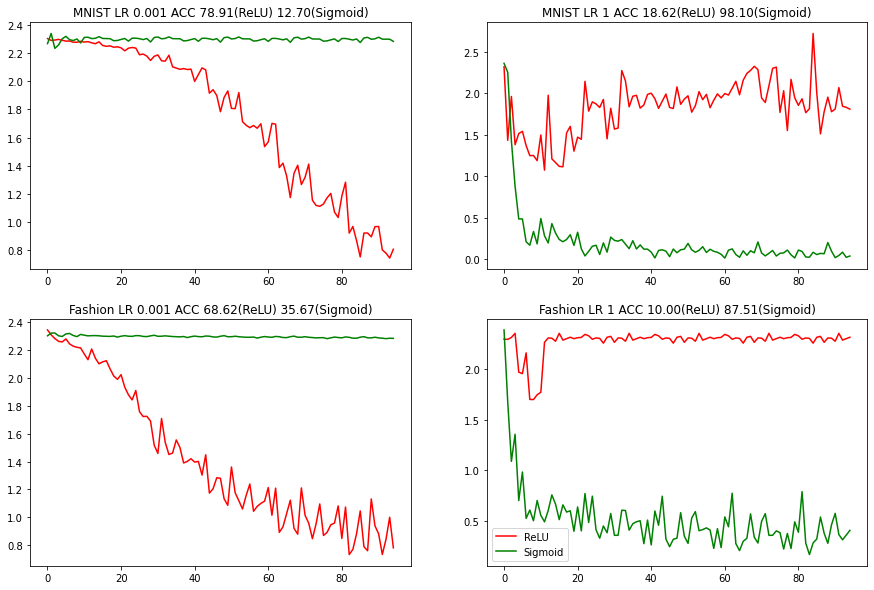

In [41]:
plt.figure(figsize=(15,10))
for ti in range(len(tt)):
    tset = 'Fashion' if ti == 1 else 'MNIST'
    for lri in range(len(lrs)):
        plt.subplot(2,2,lri+len(lrs)*ti+1)
        plt.plot(train_rr[ti][lri][0], label='ReLU', c='red')
        plt.plot(train_rr[ti][lri][1], label='Sigmoid', c='green')
        plt.title(
            f"{tset} LR {lrs[lri]} ACC "
            f"{test_rr[ti][lri][0][0]:.2f}(ReLU) "
            f"{test_rr[ti][lri][1][0]:.2f}(Sigmoid)")
plt.legend()
plt.show()